pip install xgboost

## 1. XGBoost Classification Model

### Import packages

In [235]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

### Load data

In [357]:
color = pd.read_csv("data/color.csv")
color.head()

,R,G,B,COLOR,CLASS
0,136,8,8,Blood Red,Red
1,170,74,68,Brick Red,Red
2,238,75,43,Bright Red,Red
3,165,42,42,Brown,Red
4,128,0,32,Burgundy,Red


HTML color library를 참고하여 Red, Green, Blue로 Class를 나누었습니다.  
CSV 파일에서 R, G, B는 X값으로 CLASS는 Y값으로 사용합니다.

In [358]:
cols = list(color.columns)
x_col = cols[:3]
y_col = cols[-1]

print('x colum : {}'.format(x_col))
print('y colum : {}'.format(y_col))

x colum : ['R', 'G', 'B']
y colum : CLASS


### Train / Test split

In [359]:
color_train, color_test = train_test_split(color, test_size=0.2, random_state=123)
print(color_train.shape, color_test.shape)

(103, 5) (26, 5)


### Model 생성

In [360]:
xgb_model = XGBClassifier(num_class=3,
                          n_estimators=500, 
                          learning_rate=0.2, 
                          max_depth=4,
                          eval_metric='mlogloss')

In [361]:
xgb_model.fit(X=color_train[x_col], y=color_train[y_col])

/Users/a06790/opt/anaconda3/envs/ocr_env/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=12,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='exact',
              validate_parameters=1, ...)

### Model 평가

In [362]:
xgb_pred = xgb.predict(color_test[x_col])

accuracy : [1.0]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

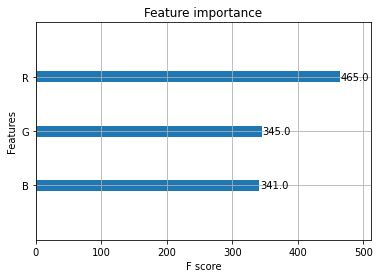

In [363]:
y_pred = xgb.predict(color_test[x_col]) # 예측치
y_true = color_test[y_col]
acc = accuracy_score(y_true, y_pred)

print('accuracy : [{}]'.format(acc))
plot_importance(xgb)

## 2. Color Detection using XGBoost Model

### Import packages

In [364]:
import cv2
import numpy as np
from scipy.spatial import distance as dist
import imutils
import matplotlib.pyplot as plt

### Function declaration

In [365]:
def img_show(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [366]:
def color_label(image, c):
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    mask = cv2.erode(mask, None, iterations=2)
    mean = cv2.mean(image, mask=mask)[:3]
    
    rgb_value = pd.DataFrame({'R': [mean[2]], 'G': [mean[1]], 'B': [mean[0]]})
    xgb_pred = xgb.predict(rgb_value)
    
    return xgb_pred[0]

### Load image

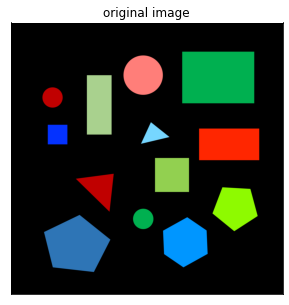

In [367]:
cv2_image = cv2.imread('asset/images/color.jpg', cv2.IMREAD_COLOR)
img_show('original image', cv2_image)

### Color Detection

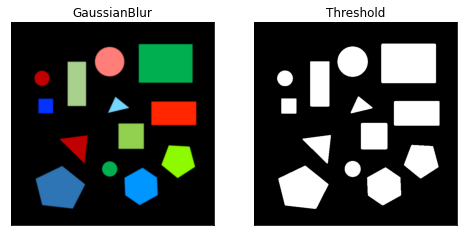

In [368]:
resized = imutils.resize(cv2_image, width=640)
ratio = cv2_image.shape[0] / float(resized.shape[0])
blurred = cv2.GaussianBlur(resized, (5, 5), 0)
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]

img_show(['GaussianBlur', 'Threshold'], [blurred, thresh])

In [369]:
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

In [370]:
vis = cv2_image.copy()

for c in cnts:
    # cv2.moments를 이용하여 객체의 중심을 계산
    M = cv2.moments(c)
    cX = int((M["m10"] / M["m00"]) * ratio)
    cY = int((M["m01"] / M["m00"]) * ratio)
    
    # 이미지에서 객체의 윤곽선과 Color를 표시
    color = color_label(resized, c)

    c = c.astype("float")
    c *= ratio
    c = c.astype("int")
    cv2.drawContours(vis, [c], -1, (0, 255, 0), 10)
    cv2.circle(vis, (cX, cY), 20, (0, 255, 0), -1); 
    cv2.putText(vis, color, (cX-80, cY-50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 5)

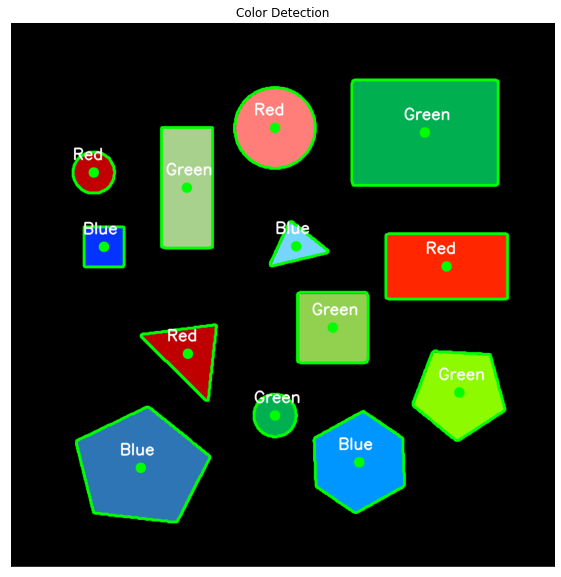

In [371]:
img_show('Color Detection', vis, figsize=(16,10))